In [1]:
import cv2
import os
from glob import glob

import itertools
import numpy as np
import matplotlib.pyplot as plt
from libs.val_libs.voc_eval_r import EVAL
from libs.configs import cfgs

/workdir


In [2]:
## ADJUST THE CODES BEFORE RUNNING IT!!!
#%cd /workdir/msc/RotationDetection/dataloader/dataset/UFRGS_CELL
#!python convert2jpg.py
#!python convert_ann2dota.py
#!python txt2xml.py

In [3]:
path_imgs = '/workdir/datasets/msc/UFRGS_CELL/comparative_annotations/imgs'
path_anns = '/workdir/datasets/msc/UFRGS_CELL/comparative_annotations/annotations'
annotators = os.listdir(path_anns)
evaler = EVAL(cfgs)

In [6]:
def get_boxes(annotation, img_name):
    path2img = os.path.join(path_imgs, img_name)
    img = cv2.imread(path2img.replace('.txt', '.jpg'))
    h,w,c = img.shape
        
    annotation = [a.split(' ')[:-1] for a in annotation.split('\n')[2:-1]]
    all_boxes_r = []
    for a in annotation:
        cls = 1 if a[-1]=='normal_cell' else 2
        pts = np.float32(a[:-1])
        pts = np.float32(list(zip(pts[::2], pts[1::2])))
        (x,y), (w,h), ang = cv2.minAreaRect(pts)

        all_boxes_r.append([cls,1.0,x,y,w,h,ang])
    
    return np.float32(all_boxes_r)

In [7]:
all_annotations = {}

for ann1,ann2 in itertools.product(annotators, repeat=2):
    
    paths_ann1 = glob(os.path.join(path_anns, ann1, 'dota_format', '*.txt'))
    
    all_boxes_r, img_list = [],[]
    for path_ann1 in paths_ann1:
        
        annotations = open(path_ann1, 'r').read()
        boxes = get_boxes(annotations, os.path.split(path_ann1)[-1])
        
        all_boxes_r.append(boxes)
        img_list.append(os.path.split(path_ann1)[-1].replace('.txt',''))
        
        if img_list[-1] not in all_annotations:
            all_annotations[img_list[-1]] = {}
        if ann1 not in all_annotations[img_list[-1]]:
            all_annotations[img_list[-1]][ann1] = boxes
        
    print(ann1, ann2)
    test_annotation_path = os.path.join(path_anns, ann2, 'xml_rotdet')
    mAps,precs,recalls = evaler.voc_evaluate_detections(all_boxes=all_boxes_r, test_imgid_list=img_list,
                                                        test_annotation_path=test_annotation_path, start_th=0.1, step_th=0.1, verbose=False)
    
    for i in range(len(precs)):
        th,ap = mAps[i]
        th,prec = precs[i]
        th,rec = recalls[i]
        print(f'Th: {np.round(th,2)} | AP: {np.round(ap,2)} | Prec: {np.round(prec,2)} | Rec: {np.round(rec,2)}')
    #th,ap = mAps[len(mAps)-1-np.argmax([ap for _,ap in mAps[::-1]])]
    #print(f'BEST: Th: {np.round(th,2)} | AP: {np.round(ap,2)}')
    print('----'*10, '\n')

Angelo Angelo
Th: 0.1 | AP: 0.91 | Prec: 1.0 | Rec: 1.0
Th: 0.2 | AP: 0.91 | Prec: 1.0 | Rec: 1.0
Th: 0.3 | AP: 0.91 | Prec: 1.0 | Rec: 1.0
Th: 0.4 | AP: 0.91 | Prec: 1.0 | Rec: 1.0
Th: 0.5 | AP: 0.91 | Prec: 1.0 | Rec: 1.0
Th: 0.6 | AP: 0.91 | Prec: 1.0 | Rec: 1.0
Th: 0.7 | AP: 0.91 | Prec: 1.0 | Rec: 1.0
Th: 0.8 | AP: 0.91 | Prec: 1.0 | Rec: 1.0
Th: 0.9 | AP: 0.91 | Prec: 1.0 | Rec: 1.0
---------------------------------------- 

Angelo Julieti
Th: 0.1 | AP: 0.61 | Prec: 0.68 | Rec: 0.9
Th: 0.2 | AP: 0.6 | Prec: 0.67 | Rec: 0.89
Th: 0.3 | AP: 0.58 | Prec: 0.64 | Rec: 0.86
Th: 0.4 | AP: 0.57 | Prec: 0.63 | Rec: 0.83
Th: 0.5 | AP: 0.48 | Prec: 0.56 | Rec: 0.75
Th: 0.6 | AP: 0.31 | Prec: 0.45 | Rec: 0.6
Th: 0.7 | AP: 0.12 | Prec: 0.26 | Rec: 0.35
Th: 0.8 | AP: 0.03 | Prec: 0.08 | Rec: 0.11
Th: 0.9 | AP: 0.0 | Prec: 0.01 | Rec: 0.01
---------------------------------------- 

Angelo Samlai
Th: 0.1 | AP: 0.69 | Prec: 0.7 | Rec: 0.98
Th: 0.2 | AP: 0.68 | Prec: 0.69 | Rec: 0.97
Th: 0.3 | AP: 

In [6]:
prec05 = [0.74, 0.77, 0.67, 0.71, 0.65, 0.67]
np.mean(prec05), np.std(prec05)

(0.7016666666666667, 0.04258977446393544)

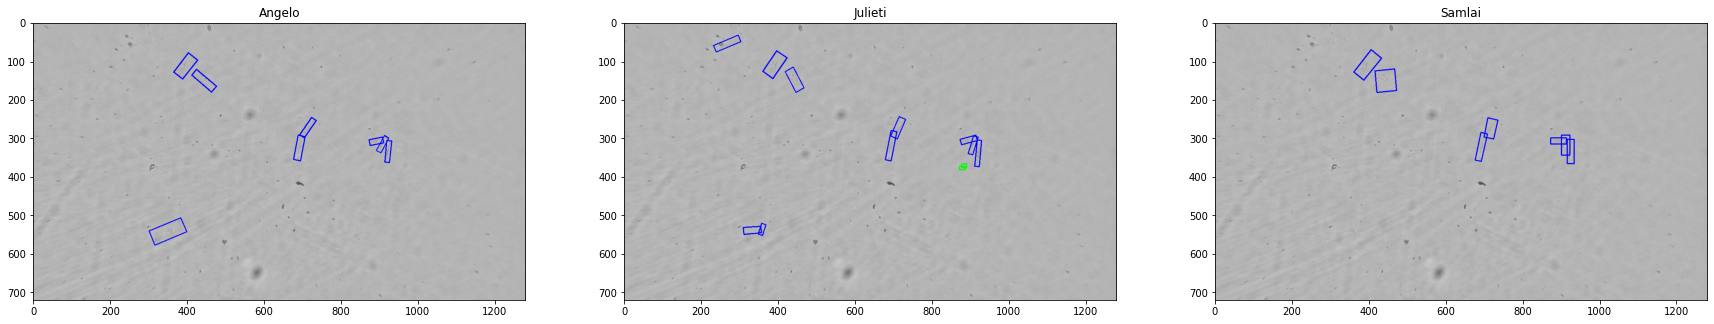

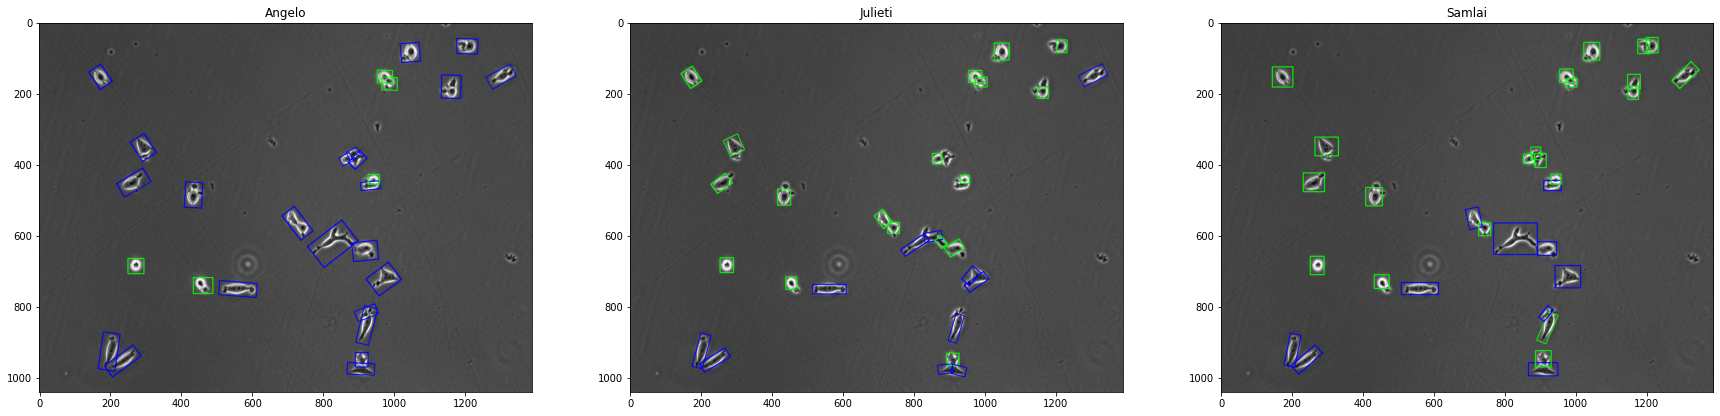

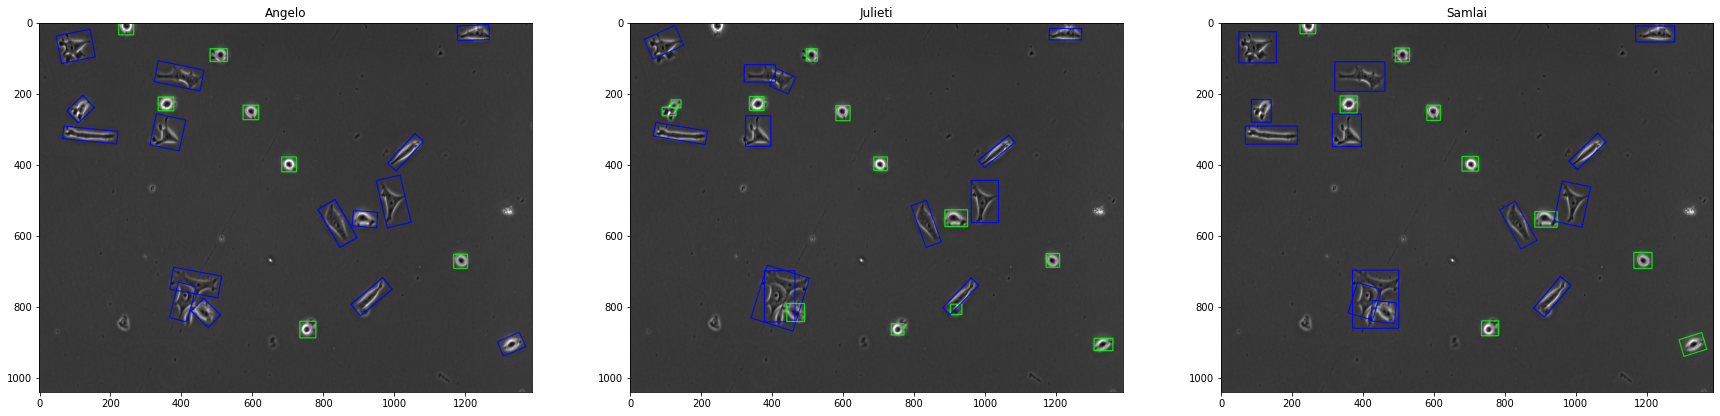

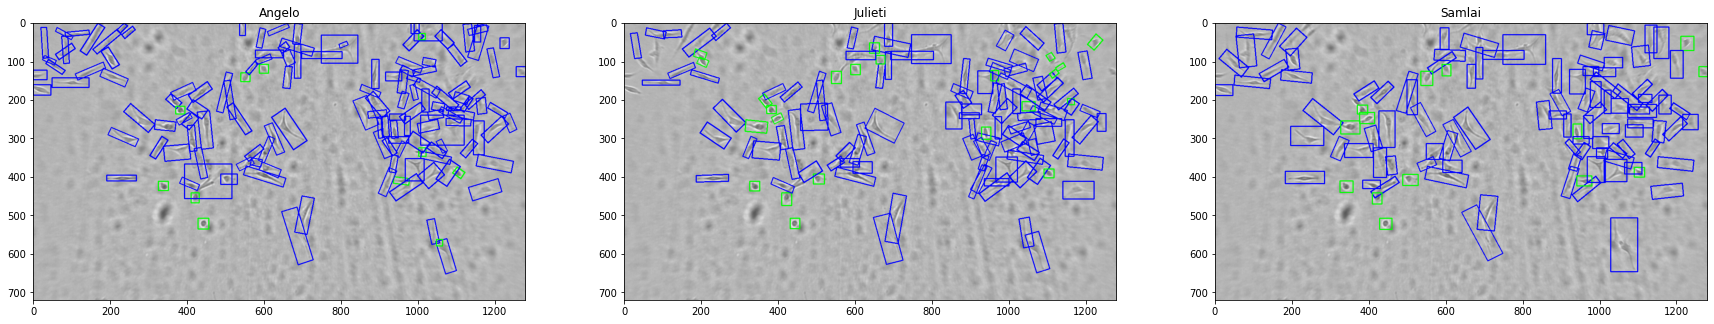

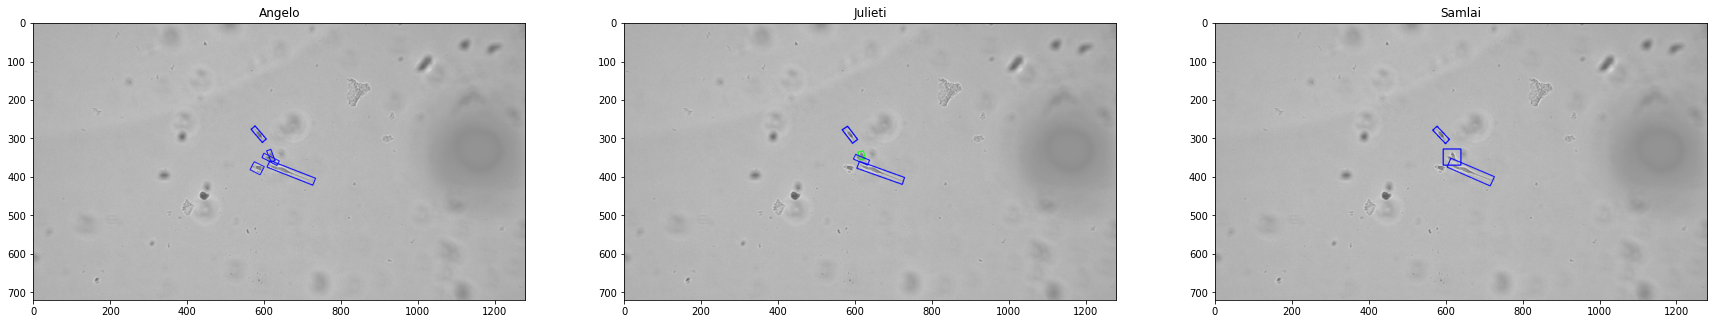

In [8]:
for img_name in all_annotations:
    plt.figure(figsize=(30,10))
    for i,ann in enumerate(all_annotations[img_name]):
        
        rects = all_annotations[img_name][ann]
        img = cv2.imread(os.path.join(path_imgs, img_name+'.jpg'))
        draw = np.copy(img)
        
        for rect in rects:
            cls = rect[0]
            color = (0,0,255) if cls==1 else (0,255,0)
            
            x,y,w,h,a = rect[2:]
            box = cv2.boxPoints(((x,y),(w,h),a))
            box = np.int0(box)
            cv2.drawContours(draw,[box],0,color,2)
            
        plt.subplot(1,3,i+1)
        plt.imshow(draw)
        plt.title(ann)